# FE511 Final Project
## Topic: Effect of News on Stock Returns
## Prepared by: Tianrui Wang
## Guided by: Prof. Stavros Tsarpalis

# 1. Thesis
Stock price prediction has been an ongoing topic both within the industry and academia. At each given point in time, the market is affected by various factors with different levels of significance. Financial data from different sources has been used in predicting the stock market: using either the historical data or the textual data from the news alone can be insufficient for a market with such volume and velocity. Furthermore, some assets might be more sensitive to the news information than the others. This project aims to evaluate the effect of company-related news on the stock prices. It is assumed that the prediction of stock returns will be improved when taking into consideration the news-related data.


# 2. Methodology

This project aims to compare the performance of a stock return prediction model with or without the use of news features. 

Section 2.1 talked about the two data sources, one is the stock-related news data found on Kaggle.com; the other is the stock data retrieved from WRDS, given the assets mentioned in the first data source. The trading period we are looking at is from 2013-01-01 to 2016-12-31. Since the original datasets are too large, I extracted a sample that contains 100 randomly selected assets, and made sure that each of them has at least 1,000 data points in the final dataset we are used for training and testing.

Section 2.2 talked about the model used, which is a regression NN model with a few Dense Layers, BatchNormalization Layers, and Dropout Layers. Also, I used an embedding layer to process a unique feature among the others, `assetCode`. It is believed that this layer is important for the model to distinguish one asset from another. The details of the model used can be found below.


## 2.1 Data
There are two source of data used in this project.


### 1. Stock-related News Data from Kaggle Competetion (https://www.kaggle.com/c/two-sigma-financial-news/data) with variables including:
    - Date
    - Asset Code (Ticker)
    - Headline (Textual Data)
    - Relevancy Info (Numerical Data)
    - Sentiment Info (Numerical Data)
    - News Artical Info (Numerical Data)
    - Time Effect of News counted by Novelty (Numerical Data)
    - Time Effect of News counted by Trading Volume (Numerical Data)
    
<img src="./img/market_data.png" width="60%">

In [1]:
# load news data
import pandas as pd
path = "/Users/shelly/Google Drive/BIA678/Kaggle-2Sigma/news_train_from2013.csv"
news_df = pd.read_csv(path)

In [2]:
# retain news from '2013-01-01' to '2016-12-30'
news_df = news_df[(news_df.time >= '2013-01-01') & (news_df.time <= '2016-12-30')]

In [3]:
# 1. Basic Processing

# drop 1st column due to reading 
news_df.drop(news_df.columns[0], axis=1, inplace=True)

# convert time to appropriate format
news_df['time'] = pd.to_datetime(news_df['time'])

# create date column - will be used for merging
news_df['date'] = pd.to_datetime(news_df['time']).dt.date

# convert bool to int
news_df['marketCommentary'] = news_df['marketCommentary'].astype(int)

# drop useless columns
news_df.drop(['time','sourceTimestamp','firstCreated', 'sourceId','provider','subjects', 'audiences','headlineTag'], axis=1, inplace=True)

In [5]:
# 2. Organize Features
# assetcode_encoded = []
# idx = ['sourceId']
time_cols = ['date']
asset_id = ['assetCodes','assetName']
text_cols = ['headline']
numeric_cols = ['urgency', 'takeSequence', 'marketCommentary', 'companyCount', 'relevance',
                'bodySize', 'sentenceCount', 'wordCount','firstMentionSentence',
                'sentimentClass', 'sentimentNegative', 'sentimentNeutral', 'sentimentPositive', 'sentimentWordCount',
                'noveltyCount12H', 'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 
                'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D', 'volumeCounts7D',]
feature_cols =  time_cols + asset_id + text_cols + numeric_cols

In [6]:
# 3. Re-organize working df
news_df = news_df[feature_cols]

In [7]:
news_df.columns

Index(['date', 'assetCodes', 'assetName', 'headline', 'urgency',
       'takeSequence', 'marketCommentary', 'companyCount', 'relevance',
       'bodySize', 'sentenceCount', 'wordCount', 'firstMentionSentence',
       'sentimentClass', 'sentimentNegative', 'sentimentNeutral',
       'sentimentPositive', 'sentimentWordCount', 'noveltyCount12H',
       'noveltyCount24H', 'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D',
       'volumeCounts12H', 'volumeCounts24H', 'volumeCounts3D',
       'volumeCounts5D', 'volumeCounts7D'],
      dtype='object')

In [8]:
# 4. 
# since each headline is associate with several assetCode
# Fix asset codes (str -> list)
news_df['assetCodes'] = news_df['assetCodes'].str.findall(f"'([\w\.]+)'")

In [9]:
# get TICKER out of assetCodes
new_list = []
for i in news_df['assetCodes'].tolist():
    temp = set()
    for j in i:
        temp.add(j.split(".")[0])
    new_list.append(list(temp))

In [10]:
news_df['assetCodes'] = new_list

In [11]:
# Expand assetCodes
from itertools import chain

assetCodes_expanded = list(chain(*news_df['assetCodes']))
assetCodes_index = news_df.index.repeat(news_df['assetCodes'].apply(len))

In [12]:
len(assetCodes_index),len(assetCodes_expanded)

(5074027, 5074027)

In [13]:
# merge with main table
df_assetCodes = pd.DataFrame({'level_0': assetCodes_index, 'assetCode': assetCodes_expanded})


In [15]:
# Create expandaded news (will repeat every assetCodes' row)
news_df_expanded = pd.merge(df_assetCodes, news_df, left_on='level_0', right_index=True)


In [16]:
# drop useless columns
news_df_expanded.drop(['level_0','assetCodes','assetName'], axis=1, inplace=True)

In [17]:
news_df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5074027 entries, 0 to 5074026
Data columns (total 27 columns):
 #   Column                Dtype  
---  ------                -----  
 0   assetCode             object 
 1   date                  object 
 2   headline              object 
 3   urgency               int64  
 4   takeSequence          int64  
 5   marketCommentary      int64  
 6   companyCount          int64  
 7   relevance             float64
 8   bodySize              int64  
 9   sentenceCount         int64  
 10  wordCount             int64  
 11  firstMentionSentence  int64  
 12  sentimentClass        int64  
 13  sentimentNegative     float64
 14  sentimentNeutral      float64
 15  sentimentPositive     float64
 16  sentimentWordCount    int64  
 17  noveltyCount12H       int64  
 18  noveltyCount24H       int64  
 19  noveltyCount3D        int64  
 20  noveltyCount5D        int64  
 21  noveltyCount7D        int64  
 22  volumeCounts12H       int64  
 23  volumeC

In [19]:
# get the assetCode list for data retrieval on WRDS
with open('assetCode.txt', 'w') as f:
    for item in set(news_df_expanded.assetCode.tolist()):
        f.write("%s\n" % item)

#### 2. Stock Price Data downloaded from WRDS (Compustat - Capital IQ) , using the ticker derived from the cleaned News Dataset. The features of interest include:
    - Date
    - Asset Code (Ticker)
    - Volume
    - Open Price
    - Close Price

#### From these variables, I will calculate the following stock returns for stock return prediction:
- returnsClosePrev1 - 1-day stock return calculated by closing price
- returnsOpenPrev1 - 1-day stock return calculated by open price
- returnsClosePrev10 - 10-day stock return calculated by closing price
- returnsOpenPrev10 - 10-day stock return calculated by open price
- returnsOpenNext10 - 10-day forward stock return calculated by open price - this will be the target variable for the regression model

In [49]:
import pandas as pd
price_df = pd.read_csv('stock.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
# drop useless columes
price_df.drop(['gvkey','iid','conm','divdpaydateind', 'divdpaydate','divsppaydate'], axis=1, inplace=True)

In [53]:
# rename the features
price_df.columns = ['date', 'assetCode','dividend','dividend_sp', 'volume', 'close', 'open']

In [54]:
price_df.head()

,date,assetCode,dividend,dividend_sp,volume,close,open
0,20130102,AIR,NaN,NaN,427126.0,19.37,19.12
1,20130103,AIR,NaN,NaN,419610.0,19.82,19.36
2,20130104,AIR,NaN,NaN,386724.0,20.11,19.92
3,20130107,AIR,NaN,NaN,303724.0,19.75,20.03
4,20130108,AIR,NaN,NaN,311604.0,19.61,19.70


In [55]:
price_df.shape

(5983319, 7)

In [57]:
# How many assets in the original dataset?
len(price_df.assetCode.unique())

7412

In [112]:
# filter the assets that have at least 1000 data points
price_df = price_df[price_df['assetCode'].map(price_df['assetCode'].value_counts()) > 1000]

In [113]:
# How many assets in the reduced dataset?
len(price_df.assetCode.unique())

4530

In [114]:
# fillna
price_df.dividend = price_df.dividend.fillna(0)
price_df.dividend_sp = price_df.dividend_sp.fillna(0)


In [115]:
# calculate closing price adjusted for dividend
price_df['adj_close'] = price_df['close'] - price_df['dividend'] - price_df['dividend_sp']

In [125]:
# calculate returnsOpenPrev1
price_df['returnsOpenPrev1'] = price_df.groupby('assetCode').open.pct_change(periods = 1)

# calculate returnsClosePrev1
price_df['returnsClosePrev1'] = price_df.groupby('assetCode').close.pct_change(periods = 1)

# calculate returnsOpenPrev10
price_df['returnsOpenPrev10'] = price_df.groupby('assetCode').open.pct_change(periods = 10)

# calculate returnsClosePrev10
price_df['returnsClosePrev10'] = price_df.groupby('assetCode').close.pct_change(periods = 10)



In [126]:
# calculate returnsOpenNext10
def tenday(open): 
    tenday = ((open.shift(-10) - open) / open) * 100
    return tenday
price_df['returnsOpenNext10'] = price_df.groupby('assetCode').open.apply(tenday)

In [128]:
# drop null values
price_df.dropna(inplace=True)

In [134]:
price_df.head()

,date,assetCode,dividend,dividend_sp,volume,close,open,adj_close,returnsOpenPrev1,returnsClosePrev1,returnsOpenPrev10,returnsClosePrev10,returnsOpenNext10
10,20130116,AIR,0.0,0.0,243247.0,19.14,19.20,19.14,0.028939,-0.008804,0.004184,-0.011874,-0.052083
11,20130117,AIR,0.0,0.0,444711.0,19.47,19.29,19.47,0.004687,0.017241,-0.003616,-0.017659,-1.918092
12,20130118,AIR,0.0,0.0,193461.0,19.61,19.42,19.61,0.006739,0.007191,-0.025100,-0.024863,-2.574665
13,20130122,AIR,0.0,0.0,253477.0,19.84,19.55,19.84,0.006694,0.011729,-0.023964,0.004557,-4.092072
14,20130123,AIR,0.0,0.0,378475.0,19.61,19.64,19.61,0.004604,-0.011593,-0.003046,0.000000,-6.008147


In [138]:
# adjust date type
price_df['date'] = price_df['date'].astype(str)

In [140]:
price_df['date'] = pd.to_datetime(price_df['date'])

In [146]:
price_df.info()

,date,assetCode,dividend,dividend_sp,volume,close,open,adj_close,returnsOpenPrev1,returnsClosePrev1,returnsOpenPrev10,returnsClosePrev10,returnsOpenNext10
10,2013-01-16,AIR,0.0,0.0,243247.0,19.14,19.20,19.14,0.028939,-0.008804,0.004184,-0.011874,-0.052083
11,2013-01-17,AIR,0.0,0.0,444711.0,19.47,19.29,19.47,0.004687,0.017241,-0.003616,-0.017659,-1.918092
12,2013-01-18,AIR,0.0,0.0,193461.0,19.61,19.42,19.61,0.006739,0.007191,-0.025100,-0.024863,-2.574665
13,2013-01-22,AIR,0.0,0.0,253477.0,19.84,19.55,19.84,0.006694,0.011729,-0.023964,0.004557,-4.092072
14,2013-01-23,AIR,0.0,0.0,378475.0,19.61,19.64,19.61,0.004604,-0.011593,-0.003046,0.000000,-6.008147


In [148]:
news_df_expanded['date'] = pd.to_datetime(news_df_expanded['date'])

In [149]:
news_df_expanded.()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5074027 entries, 0 to 5074026
Data columns (total 27 columns):
 #   Column                Dtype         
---  ------                -----         
 0   assetCode             object        
 1   date                  datetime64[ns]
 2   headline              object        
 3   urgency               int64         
 4   takeSequence          int64         
 5   marketCommentary      int64         
 6   companyCount          int64         
 7   relevance             float64       
 8   bodySize              int64         
 9   sentenceCount         int64         
 10  wordCount             int64         
 11  firstMentionSentence  int64         
 12  sentimentClass        int64         
 13  sentimentNegative     float64       
 14  sentimentNeutral      float64       
 15  sentimentPositive     float64       
 16  sentimentWordCount    int64         
 17  noveltyCount12H       int64         
 18  noveltyCount24H       int64         
 19  

### 3. Merge the two datasets on `date` & `assetCode`

In [374]:
# inner join the two datasets to make sure that the news data used is related to a particular stock on a particular day. 
df = pd.merge(price_df, news_df_expanded, how='inner',left_on=['date','assetCode'], right_on=['date','assetCode'])

In [375]:
# Since the current df is too big, I down sampled a random choice of 100 assets from the df
import random
sampling = random.choices(df.assetCode.unique(), k=100)
print(sampling)

['GM', 'FBR', 'VBFC', 'VBFC', 'HUM', 'HPTO', 'POL', 'SGF', 'ICB', 'JNS', 'AMS', 'CTXS', 'BCV', 'KBAL', 'TGH', 'SPAR', 'AAN', 'IBKC', 'PMO', 'TDS', 'ELLI', 'DCTH', 'DISCA', 'MRLN', 'CACC', 'NMFC', 'CPB', 'WEYS', 'BB', 'IMMR', 'ECL', 'KOSS', 'ARRY', 'ALQA', 'SUMR', 'UN', 'JBL', 'GM', 'BCO', 'MDT', 'ED', 'CTX', 'OSTK', 'JOUT', 'UTL', 'GPI', 'TSU', 'XLK', 'MMT', 'CUZ', 'ANGO', 'FFA', 'AMKR', 'BGG', 'CASH', 'RNVA', 'RPT', 'TSN', 'NXP', 'MTL', 'SBH', 'IDXX', 'WBA', 'TM', 'VICL', 'DYN', 'CANF', 'PFMT', 'HSNI', 'KST', 'AMRB', 'CRI', 'BHI', 'RYN', 'TSEM', 'JTA', 'MKL', 'GPRE', 'KALU', 'BWLD', 'UGP', 'LPL', 'PSTI', 'RCON', 'AEH', 'DENN', 'STZ', 'DHIL', 'UCBI', 'CTHR', 'GRC', 'NDAQ', 'THS', 'BBW', 'CERS', 'PRSS', 'SSYS', 'EXTR', 'FRBA', 'NAVG']


In [376]:
df = df[df['assetCode'].isin(sampling)]

In [377]:
df.shape

(94931, 38)

In [378]:
# define columns
y_col = ['returnsOpenNext10']
cat_cols = ['assetCode']
price_num_cols = ['volume',
             'close',
             'open',
             'adj_close',
             'returnsOpenPrev1',
             'returnsClosePrev1',
             'returnsOpenPrev10',
             'returnsClosePrev10']
news_num_cols = ['urgency',
                 'takeSequence',
                 'marketCommentary',
                 'sentimentClass',
                 'companyCount',
                 'relevance',
                 'bodySize',
                 'sentenceCount',
                 'wordCount',
                 'firstMentionSentence',
                 'sentimentNegative',
                 'sentimentNeutral',
                 'sentimentPositive',
                 'sentimentWordCount',
                 'noveltyCount12H',
                 'noveltyCount24H',
                 'noveltyCount3D',
                 'noveltyCount5D',
                 'noveltyCount7D',
                 'volumeCounts12H',
                 'volumeCounts24H',
                 'volumeCounts3D',
                 'volumeCounts5D',
                 'volumeCounts7D'
                ]
num_cols = price_num_cols+news_num_cols
time_cols = ['date']
print('Total columns to be used :',len(y_col)+len(cat_cols)+len(price_num_cols)+len(news_num_cols))

Total columns to be used : 34


### 4. Process Categorical Feature: `assetCode`

In [379]:
# convert 'assetCode' to numeric representations
cat_cols = ['assetCode']

from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values 
df[cat_cols] = labelencoder.fit_transform(df[cat_cols])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 4. Split training and testing data

In [385]:
## 4.Train Test split
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(df.index.values,test_size=0.25, random_state=23)

train_df = df.loc[train_indices,:]
test_df = df.loc[test_indices,:]
print('training data:', train_df.shape)
print('test data:', test_df.shape)

training data: (71198, 38)
test data: (23733, 38)


### 5. Process Numerical Features

In [386]:
from sklearn.preprocessing import StandardScaler


train_df[num_cols] = train_df[num_cols].fillna(0)
print('scaling price numerical columns')

scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

scaling price numerical columns


## 2.2 Model

I built two models, the baseline model and the comprehensive model to examine if using news features will increase the test accuracy on predicting the 10-day open stock return.

The baseline model takes in only the price data, and the categorical feature of `assetCode`.
The comprehensive model takes in both the price data and the news data, as well as the categorical feature.

I used embedding layer to process the assetCodes. Other than that, I only used batchnormalization and dense layer for the model.

The model can be interpretted as the following image.
<img src="./model.png" width="60%">

In [387]:
# Baseline Model

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout
from keras.losses import binary_crossentropy, mse
from keras import regularizers

# 1. categorical input - assetCode
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))
    
categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))
    categorical = Flatten()(categorical_embeddings[0])
    
categorical = Dense(32,kernel_initializer='normal',activation='relu')(categorical)


# 2. numerical input - len(price_num_cols) = 8
numerical_inputs = Input(shape=(len(price_num_cols),), name='num')
numerical = numerical_inputs
numerical = BatchNormalization()(numerical)
numerical = Dense(128,kernel_initializer='normal',activation='relu')(numerical)
numerical = Dense(64,kernel_initializer='normal',activation='relu')(numerical)

# concatenate
x = Concatenate()([numerical, categorical])
x = Dense(64,activation='relu')(x)
out = Dense(1, activation='linear')(x)
model = Model(inputs = [numerical_inputs] + categorical_inputs , outputs=out)
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                (None, 8)            0                                            
__________________________________________________________________________________________________
assetCode (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 8)            32          num[0][0]                        
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 10)        1000        assetCode[0][0]                  
___________________________________________________________________________________________

In [388]:
# Generate input regarding the model used
def get_input(df, model):
    if model == 'baseline':
        X_num = df.loc[:, price_num_cols].values
    if model == 'comprehensive':
        X_num = df.loc[:, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = df.loc[:, cat_cols].values
    
    y = df.loc[:,y_col].values

    return X,y

X_train_1,y_train_1 = get_input(train_df, 'baseline')
X_test_1,y_test_1 = get_input(test_df, 'baseline')

In [372]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=model, show_shapes=False,
    to_file='baseline_model.pdf'
)



In [389]:
history = model.fit(X_train_1, y_train_1, epochs=50, batch_size=32, validation_split = 0.2)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 56958 samples, validate on 14240 samples
Epoch 1/50
56958/56958 [==============================] - 3s 47us/step - loss: 4.8243 - mean_absolute_error: 4.8243 - val_loss: 4.7272 - val_mean_absolute_error: 4.7272
Epoch 2/50
56958/56958 [==============================] - 2s 40us/step - loss: 4.7411 - mean_absolute_error: 4.7411 - val_loss: 4.7117 - val_mean_absolute_error: 4.7117
Epoch 3/50
56958/56958 [==============================] - 2s 40us/step - loss: 4.7157 - mean_absolute_error: 4.7157 - val_loss: 4.8216 - val_mean_absolute_error: 4.8216
Epoch 4/50
56958/56958 [==============================] - 2s 40us/step - loss: 4.6863 - mean_absolute_error: 4.6863 - val_loss: 4.5924 - val_mean_absolute_error: 4.5924
Epoch 5/50
56958/56958 [==============================] - 2s 42us/step - loss: 4.6590 - mean_absolute_error: 4.6590 - val_loss: 4.8458 - val_mean_absolute_error: 4.8458
Epoch 6/50
56958/56958 [==============================] - 2s 41us/step - loss: 4.6377 - mean_absolute_err

Epoch 49/50
56958/56958 [==============================] - 2s 41us/step - loss: 4.1449 - mean_absolute_error: 4.1449 - val_loss: 3.9850 - val_mean_absolute_error: 3.9850
Epoch 50/50
56958/56958 [==============================] - 2s 41us/step - loss: 4.1338 - mean_absolute_error: 4.1338 - val_loss: 4.0697 - val_mean_absolute_error: 4.0697


### Comprehensive Model

In [392]:
len(num_cols)

32

In [394]:
# Comprehensive Model

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout
from keras.losses import binary_crossentropy, mse
from keras import regularizers

# 1. categorical input - assetCode
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))
    
categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))
    categorical = Flatten()(categorical_embeddings[0])
    
categorical = Dense(32,kernel_initializer='normal',activation='relu')(categorical)


# 2. numerical input - len(num_cols) = 32
numerical_inputs = Input(shape=(len(num_cols),), name='num')
numerical = numerical_inputs
numerical = BatchNormalization()(numerical)
numerical = Dense(128,kernel_initializer='normal',activation='relu')(numerical)
numerical = Dense(64,kernel_initializer='normal',activation='relu')(numerical)

# concatenate
x = Concatenate()([numerical, categorical])
x = Dense(64,activation='relu')(x)
out = Dense(1, activation='linear')(x)
model2 = Model(inputs = [numerical_inputs] + categorical_inputs , outputs=out)
model2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model2.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                (None, 32)           0                                            
__________________________________________________________________________________________________
assetCode (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 32)           128         num[0][0]                        
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 10)        1000        assetCode[0][0]                  
___________________________________________________________________________________________

In [395]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model2, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=model2, show_shapes=False,
    to_file='comprehensive_model.pdf'
)



In [396]:
X_train_2,y_train_2 = get_input(train_df, 'comprehensive')
X_test_2,y_test_2 = get_input(test_df, 'comprehensive')

In [397]:
history2 = model2.fit(X_train_2, y_train_2, epochs=50, batch_size=32, validation_split = 0.2)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 56958 samples, validate on 14240 samples
Epoch 1/50
56958/56958 [==============================] - 3s 48us/step - loss: 4.8301 - mean_absolute_error: 4.8301 - val_loss: 4.8287 - val_mean_absolute_error: 4.8287
Epoch 2/50
56958/56958 [==============================] - 2s 43us/step - loss: 4.7359 - mean_absolute_error: 4.7359 - val_loss: 4.7221 - val_mean_absolute_error: 4.7221
Epoch 3/50
56958/56958 [==============================] - 3s 44us/step - loss: 4.6941 - mean_absolute_error: 4.6941 - val_loss: 4.8265 - val_mean_absolute_error: 4.8265
Epoch 4/50
56958/56958 [==============================] - 2s 44us/step - loss: 4.6482 - mean_absolute_error: 4.6482 - val_loss: 4.7390 - val_mean_absolute_error: 4.7390
Epoch 5/50
56958/56958 [==============================] - 2s 43us/step - loss: 4.6067 - mean_absolute_error: 4.6067 - val_loss: 4.6295 - val_mean_absolute_error: 4.6295
Epoch 6/50
56958/56958 [==============================] - 2s 43us/step - loss: 4.5653 - mean_absolute_err

Epoch 49/50
56958/56958 [==============================] - 2s 42us/step - loss: 3.8851 - mean_absolute_error: 3.8851 - val_loss: 4.3287 - val_mean_absolute_error: 4.3287
Epoch 50/50
56958/56958 [==============================] - 2s 41us/step - loss: 3.8781 - mean_absolute_error: 3.8781 - val_loss: 3.7397 - val_mean_absolute_error: 3.7397


# 3. Results


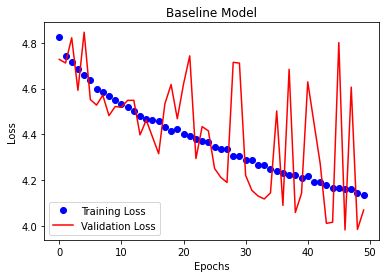

In [404]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Baseline Model')
plt.show()

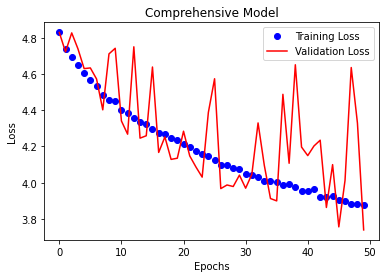

In [405]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Comprehensive Model')
plt.show()

In [391]:
loss = model.evaluate(X_test_1,y_test_1)
print('loss = ' + str(loss))

23733/23733 [==============================] - 0s 11us/step
loss = [4.0700893284663415, 4.070091724395752]


In [398]:
loss2 = model2.evaluate(X_test_2,y_test_2)
print('loss = ' + str(loss2))

23733/23733 [==============================] - 0s 14us/step
loss = [3.766928488649772, 3.76692795753479]


In [402]:
result = [('Baseline', loss[0]),('Comprehensive', loss2[0])]
result_df = pd.DataFrame(result, columns = ['Model', 'loss/mean_absolute_error']) 


In [403]:
result_df

,Model,loss/mean_absolute_error
0,Baseline,4.830115
1,Comprehensive,3.766928


In [1]:
(3.766928 - 4.830115)/4.830115

-0.22011629122702048

# 4. Discussion

Through the comparison in the result table, we could see that the comprehensive model performed slightly better than the baseline model, with the news data as extra input to the regression model. From the loss vs epochs plot we could also observed that there is basically no overfitting issue, probably due to adding the batchNormalization layers.

The result shows a potential significant effect of the news data on the stock returns. In fact, the training has been done more than once, and each training results in a different level of loss (e.g. one training resulted in a mean absolute error of around 12). It is believed that the result will flucuate when different assets are selected.

Currently, the result could not prove that the news data is useful for predicting stock returns, especially when we are using only 100 assets selected from the pool. To prove that there are significant differences between the baseline model and the comprehensive model, we should do over 30 random tests and generate an average loss for the two models. A lot of improvements can be done in the future.

